In [1]:
import sys
import os

# Add the outer mcerp folder (the one containing the inner mcerp package)
print(os.getcwd())
module_path = os.path.abspath("mcerp_outer")
os.chdir(module_path)
print(os.getcwd())

import mcerp
print(mcerp.correlation_matrix)


c:\Users\AUSM504495\Documents\GitHub\WSP_PSI
c:\Users\AUSM504495\Documents\GitHub\WSP_PSI\mcerp_outer


c:\Users\AUSM504495\Documents\GitHub\WSP_PSI\mcerp_outer\mcerp\__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


<function correlation_matrix at 0x0000014D29F48680>


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mcerp import correlate
from mcerp import correlation_matrix
from mcerp.correlate import plotcorr
from mcerp import Beta, N, Exp, PERT
from mcerp import uv, stats
# from mcerp import *

from scipy import stats as stats
from scipy.stats import rv_continuous, beta, genextreme, rv_histogram
import scipy.optimize as opt


import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:.3f}'.format

nR = 10000

In [74]:
# distribution parameters:
min, mode, max, lmb = 8000.0, 12000.0, 18000.0, 4.0         # sales volume, PERT estimae
ms, ss = 20.0, 1.0                                          # selling price, normally distributed
mm, sm = 13.0, 0.7                                          # material unit cost, normally distributed 
o = 3.0                                                     # other unit cost, deterministic 

In [75]:
# setting up the simulation model BEFORE calibrating correlations:

# input variables:
v1 = PERT(min, mode, max, lmb)                  # sales volume, PERT distributed
p1 = N(ms, ss)                                  # selling price, normally distributed
m1 = N(mm, sm)                                  # material unit cost, normally distributed 
o1 = o                                          # other unit cost, deterministic    


# output variables:
GP1 = v1 * (p1 - m1 - o1)                       # simulation output: Gross Profit
R1 = v1 * p1                                    # simulation output: Revenues
GM1 = GP1 / R1                                  # simulation output: Gross Margin
C1 = R1 - GP1                                   # simulation output: Total Cost

In [ ]:
# run the simulation model, 
# and collect the results in array variables

# number of mcerp samples
npts = nR

# assign the 6x 10,000 values to 6 variables so we can process their arrays later
rv1 = v1._mcpts
rp1 = p1._mcpts
rm1 = m1._mcpts
rGP1 = GP1._mcpts
rR1 = R1._mcpts
rGM1 = GM1._mcpts

# combine the 6 arrays in a 2-dimensional array
rand1 = np.vstack((rv1, rp1, rm1, rGP1, rR1, rGM1))

# copy the array to a dataframe for a more transparent layout
df1 = pd.DataFrame(data=rand1).T 
df1.rename(columns={ 
    0:"volume 1", 1:"price 1", 2:"material 1", 3:"Gross Profit 1", 4:"Revenues 1", 5:"Gross Margin 1"}, 
    inplace=True)
df1

[[ 11320.093  13793.28   15417.553 ...  11935.418  10061.089  11286.085]
 [    19.349     20.905     19.269 ...     19.972     20.405     20.367]
 [    12.431     13.801     13.27  ...     12.675     11.866     12.821]
 [ 37007.773  70163.998  52616.941 ...  52229.127  58240.026  52278.963]
 [217101.875 291972.245 304391.246 ... 237847.491 201679.884 228314.522]
 [     0.17       0.24       0.173 ...      0.22       0.289      0.229]]


,volume 1,price 1,material 1,Gross Profit 1,Revenues 1,Gross Margin 1
0,11320.093,19.349,12.431,37007.773,217101.875,0.170
1,13793.280,20.905,13.801,70163.998,291972.245,0.240
2,15417.553,19.269,13.270,52616.941,304391.246,0.173
3,14692.338,19.331,13.049,52522.665,289195.515,0.182
4,11406.692,21.348,13.757,58144.805,242727.673,0.240
...,...,...,...,...,...,...
9995,10069.127,19.985,12.308,42129.032,197500.109,0.213
9996,10734.838,19.545,12.957,26449.920,207061.607,0.128
9997,11935.418,19.972,12.675,52229.127,237847.491,0.220
9998,10061.089,20.405,11.866,58240.026,201679.884,0.289


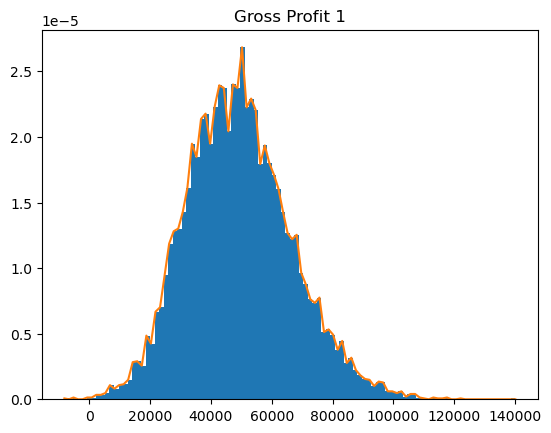

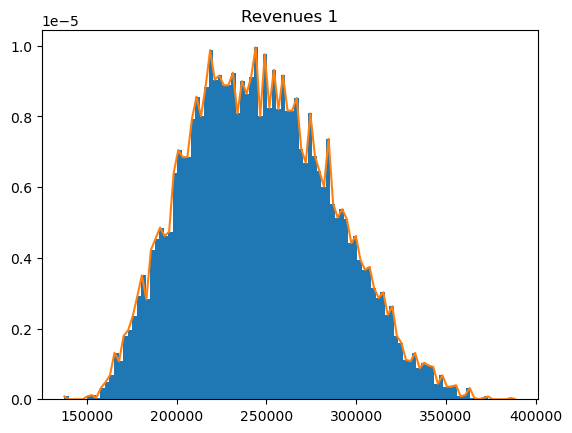

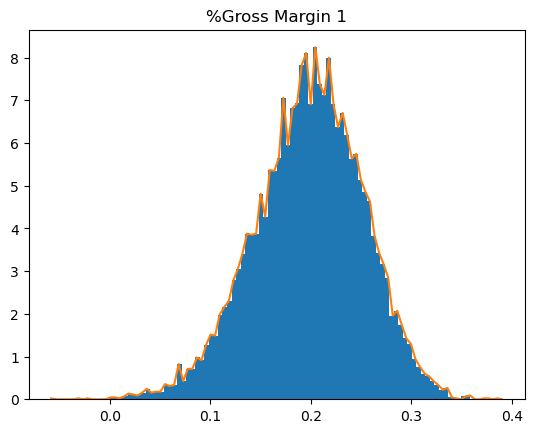

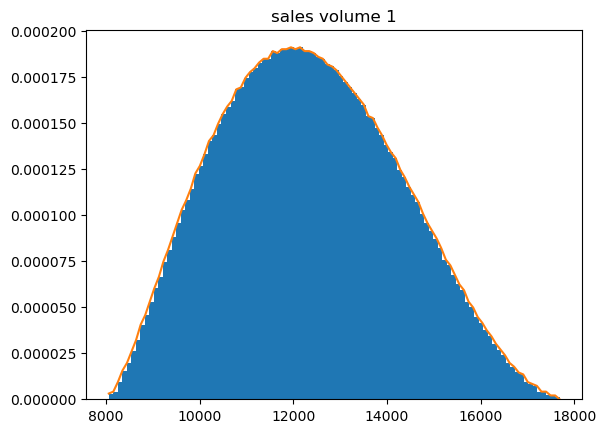

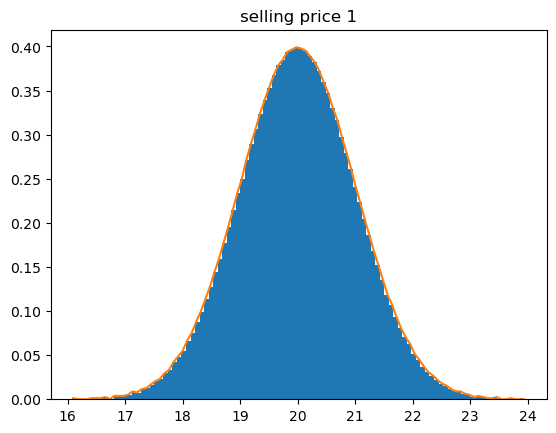

In [77]:
# helper function: plot histogram
def plot_hist(data, title):
    hist = np.histogram(data, bins=100)
    histdist = rv_histogram(hist)

    X = np.linspace(data.min(), data.max(), 100)
    plt.title(title)
    plt.hist(data, density=True, bins=100)
    plt.plot(X, histdist.pdf(X))
    plt.show()
    
    
    # results: draw histograms
plot_hist(rGP1, "Gross Profit 1")
plot_hist(rR1, "Revenues 1")
plot_hist(rGM1, "%Gross Margin 1")
plot_hist(rv1, "sales volume 1")
plot_hist(rp1, "selling price 1")

[[ 1.     0.005 -0.015]
 [ 0.005  1.     0.003]
 [-0.015  0.003  1.   ]]


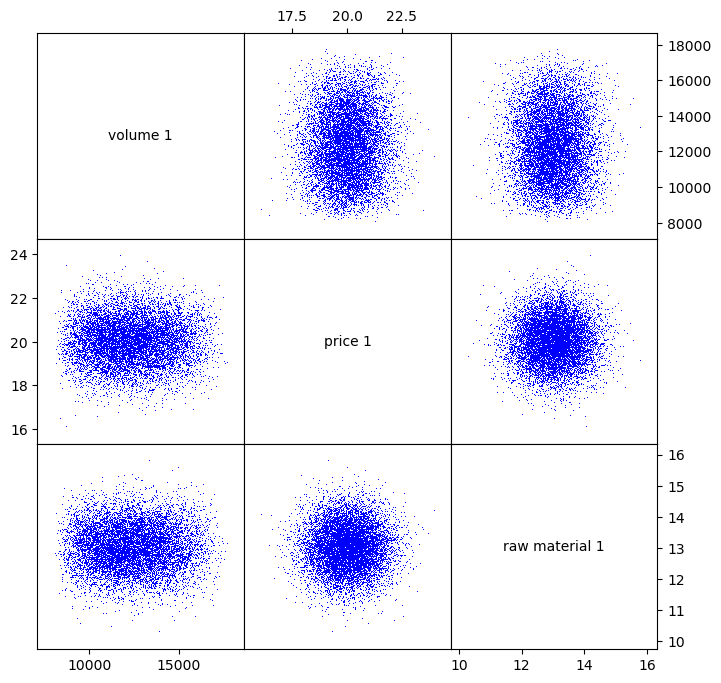

In [78]:
# get the correlation matrix BEFORE recalibrating
c1 = correlation_matrix([v1, p1, m1])
print(c1)

# plot correlations BEFORE recalibrating
corrplot0 = plotcorr([v1, p1, m1], labels=["volume 1", "price 1", "raw material 1"])

In [ ]:
# targeted correlation matrix: volume, price, material unit cost
c_target = np.array(    [[  1.0, -0.3,  0.2],
                        [  -0.3,  1.0,  0.7],
                        [   0.2,  0.7,  1.0]])

# impose the targeted correlation matrix on the 3 input variables
v2=v1
p2=p1
m2=m1
o2=o1
correlate([v2, p2, m2], c_target)

NameError: name 'np' is not defined

[[ 1.    -0.299  0.199]
 [-0.299  1.     0.7  ]
 [ 0.199  0.7    1.   ]]


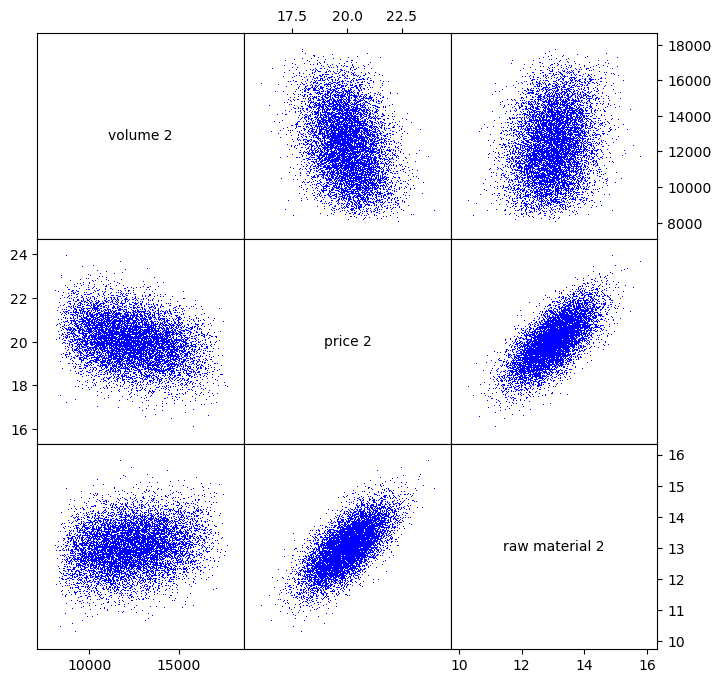

In [80]:
c2 = correlation_matrix([v2, p2, m2])
print(c2)

# deviations from targeted correlations
c2 - c_target

# plot the new correlation matrix of the input variables
corrplot2 = plotcorr([v2, p2, m2], labels=["volume 2", "price 2", "raw material 2"])

      volume 2  price 2  material 2  Gross Profit 2  Revenues 2  \
0    11320.093   19.349      12.431       44354.697  219036.995   
1    13793.280   20.905      13.801       56600.602  288342.843   
2    15417.553   19.269      13.270       46239.511  297080.348   
3    14692.338   19.331      13.049       48219.534  284022.202   
4    11406.692   21.348      13.757       52369.872  243515.497   
...        ...      ...         ...             ...         ...   
9995 10069.127   19.985      12.308       47090.445  201229.538   
9996 10734.838   19.545      12.957       38516.117  209810.045   
9997 11935.418   19.972      12.675       51276.895  238369.227   
9998 10061.089   20.405      11.866       55727.784  205292.522   
9999 11286.085   20.367      12.821       51305.685  229859.874   

      Gross Margin 2  
0              0.202  
1              0.196  
2              0.156  
3              0.170  
4              0.215  
...              ...  
9995           0.234  
9996       

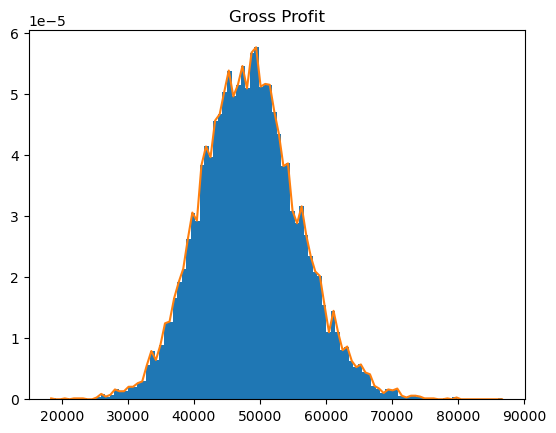

In [81]:
# output variables:
# we rename the output variables to use consistent variable names in simu1 and simu2
GP2 = v2 * (p2 - m2 - o2)                       # simulation output: Gross Profit
R2 = v2 * p2                                    # simulation output: Revenues
GM2 = GP2 / R2                                  # simulation output: Gross Margin
C2 = R2 - GP2                                   # simulation output: Total Cost

# assign the 6x 10,000 variates to 6 variables so we can process their arrays later
rv2 = v2._mcpts
rp2 = p2._mcpts
rm2 = m2._mcpts
rGP2 = GP2._mcpts
rR2 = R2._mcpts
rGM2 = GM2._mcpts

# combine the 6 arrays in a 2-dimensional array
rand2 = np.vstack((rv2, rp2, rm2, rGP2, rR2, rGM2))

# copy the array to a dataframe for a more transparent layout
df2 = pd.DataFrame(data=rand2).T 
df2.rename(columns={ 
    0:"volume 2", 1:"price 2", 2:"material 2", 3:"Gross Profit 2", 4:"Revenues 2", 5:"Gross Margin 2"}, 
    inplace=True)
print(df2)

# results: draw histograms
plot_hist(rGP2, "Gross Profit")

In [1]:
import warnings
warnings.resetwarnings()